In [55]:
'''
Description: 
Version: 1.0
Autor: SHAO Nuoya
Date: 2021-12-03 13:46:17
LastEditors: SHAO Nuoya
LastEditTime: 2021-12-05 01:05:54
FilePath: \EDP-in-Finance\TP1.ipynb
'''

'\nDescription: \nVersion: 1.0\nAutor: SHAO Nuoya\nDate: 2021-12-03 13:46:17\nLastEditors: SHAO Nuoya\nLastEditTime: 2021-12-05 01:05:54\nFilePath: \\EDP-in-Finance\\TP1.ipynb\n'

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.sparse import csr_matrix as sparse
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

np.set_printoptions(suppress=True)

In [57]:
class BS:
    def __init__(self,
                 K=100,
                 S_min=0,
                 S_max=200,
                 T=1,
                 sigma=0.2,
                 r=0.1,
                 N=10,
                 I=10):
        self.K = K
        self.S_min = S_min
        self.S_max = S_max
        self.T = T
        self.sigma = sigma
        self.r = r
        self.N = N
        self.I = I

        self.h = (S_max - S_min) / I
        self.dt = T / N

        self.S = np.linspace(S_min, S_max, I).reshape(-1, 1)
        self.Sval = np.mean(self.S)
        self.alpha = sigma**2 * self.S**2 / (2 * self.h**2)
        self.beta = r * self.S / (2 * self.h)

    def get_A(self) -> np.ndarray:
        I = self.I
        A = np.zeros((I, I))
        for i in range(I):
            A[i, i] = 2 * self.alpha[i] + self.r

        for i in range(I - 1):
            A[i + 1, i] = -self.alpha[i + 1] + self.beta[i + 1]
            A[i, i + 1] = -self.alpha[i] - self.beta[i]
        return A

    # Boundary condition
    def phi(self) -> np.ndarray:
        return np.maximum(self.K - self.S, 0).reshape(self.I, 1)

    def uleft(self, U: np.ndarray) -> float:
        return (-self.alpha[0] + self.beta[0]) * U[0]

    def uright(self, U: np.ndarray) -> float:
        return (-self.alpha[-1] - self.beta[-1]) * U[-1]

    def get_price(self, method: str) -> np.ndarray:
        U = np.array(self.phi())
        q = np.zeros((self.I, 1))
        A = self.get_A()
        for t in range(self.N):
            q[0] = self.uleft(U)
            q[-1] = self.uright(U)
            if method == 'EE':
                U = (np.eye(self.I) - self.dt * A) @ U - self.dt * q
            if method == 'IE':
                U = np.linalg.solve(A + np.eye(self.I) / self.dt,
                                    np.eye(self.I) / self.dt @ U - q)
            if method == 'CN':
                U = np.linalg.solve(A / 2 + np.eye(self.I) / self.dt,
                                    (-A / 2 + np.eye(self.I) / self.dt) @ U -
                                    q)

        return U

In [58]:
def plot(method: str, I: int, N: int) -> None:
    bs = BS(I=I, N=N)
    U = bs.get_price(method)
    # plt.subplot(3, 3, index)
    plt.plot(bs.S, U)
    plt.plot(bs.S, bs.phi(), linestyle='--')
    plt.title('I = {}, N = {}, K = {}'.format(bs.I, bs.N, bs.K))
    plt.xlabel('S0')
    plt.ylabel('Payoff')
    plt.grid()

# Explicit Euler (EE) scheme

## a) Test the Euler forward scheme (EE). 
First fix N = 10 and take I = 10,20,50,....Then take the following N = I values : 10,20,50,100

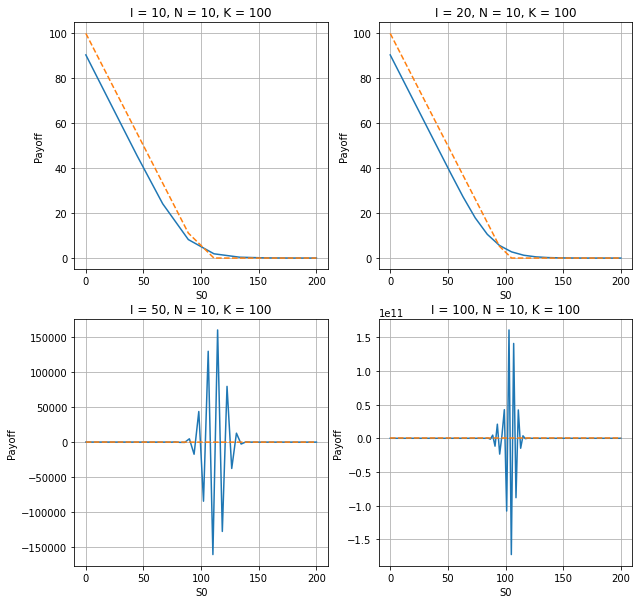

In [59]:
  Is = [10, 20, 50, 100]
  N = 10
  
  plt.figure(figsize=(10, 10))
  for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('EE', I, N)

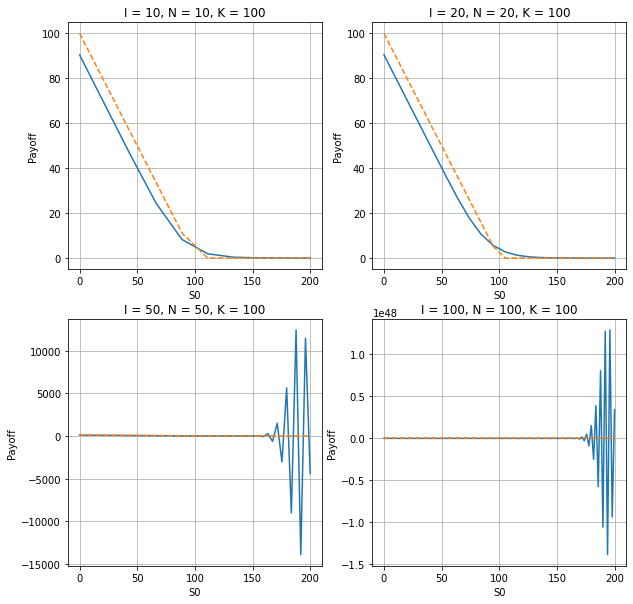

In [60]:
  Is = [10, 20, 50, 100]
  
  plt.figure(figsize=(10, 10))
  for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    N = I
    plot('EE', I, N)

## b) Understand the origin of the oscillations or explosion when they occur
Fix N = 10 and I = 50, and look at the "amplification" matrix defined as
$$B := Id −∆tA$$

In [61]:
N = 10
I = 50
bs = BS(N=N, I=I)
A = bs.get_A()
B = np.eye(A.shape[0]) - bs.dt * A
B = np.round(B, 3)
print(B)

norm_inf = np.linalg.norm(B, np.inf)
norm_2 = np.linalg.norm(B, 2)
print('norm_inf: {}\nnorm_2: {}'.format(norm_inf, norm_2))

[[ 0.99   0.     0.    ...  0.     0.     0.   ]
 [-0.003  0.986  0.007 ...  0.     0.     0.   ]
 [ 0.    -0.002  0.973 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ... -8.21   4.84   0.   ]
 [ 0.     0.     0.    ...  4.553 -8.606  5.043]
 [ 0.     0.     0.    ...  0.     4.75  -9.01 ]]
norm_inf: 18.201999999999998
norm_2: 16.44588908462899


We see clearly that the coefficients of B are not all positive and that they may have a modulus greater than 1 <br>
When $N=10$, $I=50$, $||B||_2$ and $||B||_{\infty}$ are larger than 1

In [62]:
N = 10
I = 10
bs = BS(N=N, I=I)
A = bs.get_A()
B = np.eye(A.shape[0]) - bs.dt * A
B = np.round(B, 3)
print(B)

norm_inf = np.linalg.norm(B, np.inf)
norm_2 = np.linalg.norm(B, 2)
print('norm_inf: {}\nnorm_2: {}'.format(norm_inf, norm_2))

[[ 0.99   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.003  0.985  0.008  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.001  0.97   0.021  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.006  0.946  0.039  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.017  0.911  0.062  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.034  0.867  0.09   0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.056  0.812  0.122  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.082  0.748  0.16   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.114  0.674  0.202]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.15   0.59 ]]
norm_inf: 0.996
norm_2: 0.9904894166526466


We see clearly that the coefficients of B are (almost) all positive, and smaller than 1 <br>
When $N=10$, $I=10$, $||B||_2$ and $||B||_{\infty}$ are smaller than 1

## c) Compute the CFL number

In [63]:
def CFL(dt, h, sigma, Smax):
    return dt * sigma**2 * Smax**2 / (h**2)


In [64]:
N1 = 10
I1 = 10
N2 = 10
I2 = 50
bs1 = BS(N=N1, I=I1)
bs2 = BS(N=N2, I=I2)
CFL1 = CFL(bs1.dt, bs1.h, bs1.sigma, bs1.S_max)
CFL2 = CFL(bs2.dt, bs2.h, bs2.sigma, bs2.S_max)
print('When N = 10, I = 10, mu = {}\nWhen N = 10, I = 50, mu = {}'.format(
    CFL1, CFL2))


When N = 10, I = 10, mu = 0.4000000000000001
When N = 10, I = 50, mu = 10.000000000000002


Hence there is no stability problem when $\mu$ is sufficiently small.

## d)  Compute the P1-interpolated value at $\overline{s}$ = 90

In [65]:
def P1(s_bar, bs, method):
    U = bs.get_price(method)

    for i in range(len(bs.S)):
        if bs.S[i] <= s_bar and bs.S[i + 1] >= s_bar:
            index = i
            break
    s_i = bs.S[index]
    s_ii = bs.S[index + 1]
    P1_S = (s_ii - s_bar) * U[index] / bs.h + (s_bar - s_i) * U[index +
                                                                1] / bs.h

    return P1_S[0]

In [66]:
N = I = 10
s_bar = 90
bs = BS(N=N, I=I)
P1_S = P1(s_bar, bs, 'EE')
print('When N = {}, I = {}, PI approximation = {}'.format(N, I, P1_S))

When N = 10, I = 10, PI approximation = 8.792522992351646


## e) Numerical order of the scheme

In [67]:
def dic() -> dict:
    dic = {'I': [], 'N': [], 'U(s_)': [], 'e_k': [], 'order_alpha_k': []}
    return dic


def get_order_alpha(e_k_1, e_k, h_k_1, h_k) -> float:
    return np.log(e_k_1 / e_k) / np.log(h_k_1 / h_k)


### N=I

In [68]:
values = [10, 20, 40, 80, 160]
s_ = 80
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for i in range(len(values)):
    N = I = values[i]
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'EE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,10,1.622489e+01,NaN,NaN
1,20,20,1.428269e+01,-1.942200e+00,NaN
2,40,40,1.367040e+01,-6.122900e-01,1.66541
3,80,80,-3.627411e+03,-3.641081e+03,-12.53787
4,160,160,-2.779584e+69,-2.779584e+69,-218.85776


### N=$I^2$/10

In [69]:
Is = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for i in range(len(Is)):
    I = Is[i]
    N = I**2 // 10
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'EE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,10,16.22489,NaN,NaN
1,20,40,14.31518,-1.90972,NaN
2,40,160,13.69536,-0.61982,1.62344
3,80,640,13.46157,-0.23378,1.40667
4,160,2560,13.36210,-0.09948,1.23271
5,320,10240,13.31652,-0.04557,1.12623


# Implicit Euler (IE) scheme

## a) Check that with the IE scheme there is no more stability problems

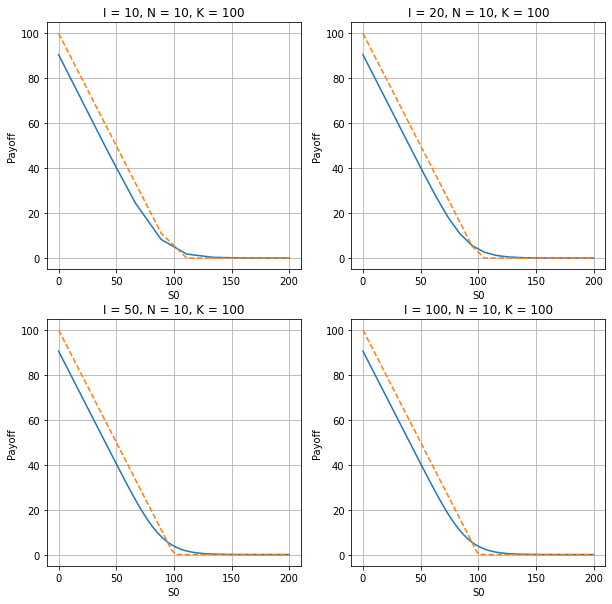

In [70]:
  Is = [10, 20, 50, 100]
  N = 10
  
  plt.figure(figsize=(10, 10))
  for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('IE', I, N)

We see clearly that with the IE scheme there is no more stability problems

## b) Draw the corresponding table with N = I and with N = I/10

### N=I

In [71]:
values = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for i in range(len(values)):
    N = I = values[i]
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'IE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,10,16.41135,NaN,NaN
1,20,20,14.41064,-2.00072,NaN
2,40,40,13.73674,-0.67390,1.56991
3,80,80,13.48023,-0.25651,1.39353
4,160,160,13.37090,-0.10933,1.23030
5,320,320,13.32079,-0.05011,1.12566


### N=I/10

In [72]:
Is = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for i in range(len(Is)):
    I = Is[i]
    N = I // 10
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'IE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,1,17.06841,NaN,NaN
1,20,2,14.91661,-2.15180,NaN
2,40,4,14.02212,-0.89449,1.26640
3,80,8,13.62726,-0.39486,1.17972
4,160,16,13.44501,-0.18225,1.11543
5,320,32,13.35794,-0.08706,1.06581


# Crank-Nicolson scheme

## a) Program the Crank-Nicolson scheme (CN)

$$(\frac{A}{2}+\frac{Id}{dt})*U^{n+1} = (\frac{-A}{2}+\frac{Id}{dt})*U^n-q_n$$

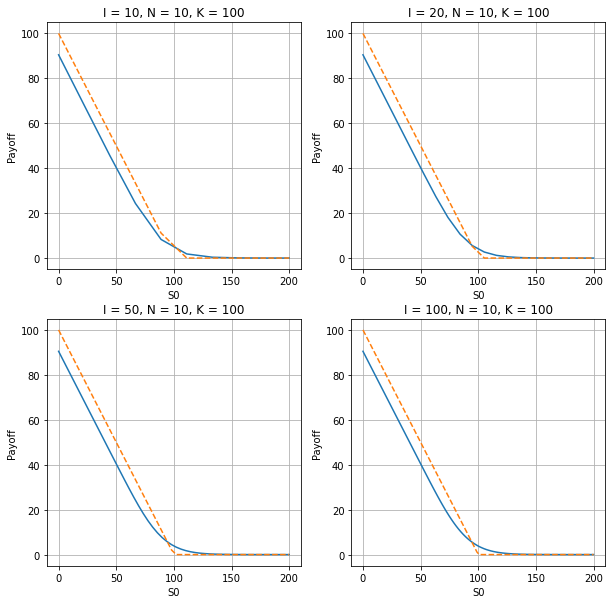

In [73]:
  Is = [10, 20, 50, 100]
  N = 10
  
  plt.figure(figsize=(10, 10))
  for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('CN', I, N)

## b) Draw the corresponding table with N = I and N = I/10

### N=I

In [74]:
values = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for i in range(len(values)):
    N = I = values[i]
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'CN')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,10,16.31950,NaN,NaN
1,20,20,14.34665,-1.97285,NaN
2,40,40,13.70345,-0.64320,1.61694
3,80,80,13.46360,-0.23986,1.42311
4,160,160,13.36260,-0.10100,1.24786
5,320,320,13.31665,-0.04595,1.13613


### N=I/10

In [75]:
Is = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for i in range(len(Is)):
    I = Is[i]
    N = I // 10
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'CN')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,1,16.19530,NaN,NaN
1,20,2,14.27457,-1.92073,NaN
2,40,4,13.68480,-0.58977,1.70342
3,80,8,13.45838,-0.22642,1.38118
4,160,16,13.36130,-0.09708,1.22166
5,320,32,13.31632,-0.04497,1.11019


# Conclusion on numerical tests. 

We observe that with the same discretization, the Crank-Nicolson scheme can give the most accurate result and implicit schema is better than explicit schema, which is coherent with the theoretical analysis. 

# Complement 1: program the sparse matrices

In [76]:
class BS_sparse:
    def __init__(self,
                 K=100,
                 S_min=0,
                 S_max=200,
                 T=1,
                 sigma=0.2,
                 r=0.1,
                 N=10,
                 I=10):
        self.K = K
        self.S_min = S_min
        self.S_max = S_max
        self.T = T
        self.sigma = sigma
        self.r = r
        self.N = N
        self.I = I

        self.h = (S_max - S_min) / I
        self.dt = T / N

        self.S = np.linspace(S_min, S_max, I).reshape(-1, 1)
        self.Sval = np.mean(self.S)
        self.alpha = sigma**2 * self.S**2 / (2 * self.h**2)
        self.beta = r * self.S / (2 * self.h)

    def get_A(self) -> np.ndarray:
        I = self.I
        A = np.zeros((I, I))
        for i in range(I):
            A[i][i] = float(2 * self.alpha[i] + self.r)

        for i in range(I - 1):
            A[i + 1][i] = float(-self.alpha[i + 1] + self.beta[i + 1])
            A[i][i + 1] = float(-self.alpha[i] - self.beta[i])

        return sparse(A)

    # Boundary condition
    def phi(self) -> np.ndarray:
        return np.maximum(self.K - self.S, 0).reshape(self.I, 1)

    def uleft(self, U: np.ndarray) -> float:
        return (-self.alpha[0] + self.beta[0]) * U[0]

    def uright(self, U: np.ndarray) -> float:
        return (-self.alpha[-1] - self.beta[-1]) * U[-1]

    def get_price(self, method: str) -> np.ndarray:
        U = np.array(self.phi()).reshape(-1, 1)
        q = np.zeros((self.I, 1))
        A = self.get_A()

        for t in range(self.N):
            q[0] = self.uleft(U)
            q[-1] = self.uright(U)
            if method == 'EE':
                U = (np.eye(self.I) - self.dt * A) @ U - self.dt * q
            if method == 'IE':
                Id = sparse(np.eye(self.I))
                U = spsolve(A + Id / self.dt, Id / self.dt @ U - q)
                U = U.reshape(I, 1)
            if method == 'CN':
                Id = sparse(np.eye(self.I))
                U = spsolve(A / 2 + Id / self.dt,
                            (-A / 2 + Id / self.dt) @ U - q)
                U = U.reshape(I, 1)
        return U

In [77]:
I, N = 1000, 100
bs = BS(I=I, N=N)
bs_sparse = BS_sparse(I=I, N=N)

# EE
t0_EE = time.time()
bs.get_price('EE')
t1_EE = time.time()

t0_EE_sparse = time.time()
bs_sparse.get_price('EE')
t1_EE_sparse = time.time()

# IE
t0_IE = time.time()
bs.get_price('IE')
t1_IE = time.time()

t0_IE_sparse = time.time()
bs_sparse.get_price('IE')
t1_IE_sparse = time.time()

# CN
t0_CN = time.time()
bs.get_price('CN')
t1_CN = time.time()

t0_CN_sparse = time.time()
bs_sparse.get_price('CN')
t1_CN_sparse = time.time()

print('tcpu for EE = %5.2f' % (t1_EE - t0_EE))
print('tcpu for EE sparse = %5.2f' % (t1_EE_sparse - t0_EE_sparse))
print('tcpu for IE = %5.2f' % (t1_IE - t0_IE))
print('tcpu for IE sparse = %5.2f' % (t1_IE_sparse - t0_IE_sparse))
print('tcpu for CN = %5.2f' % (t1_CN - t0_CN))
print('tcpu for CN sparse = %5.2f' % (t1_CN_sparse - t0_CN_sparse))


tcpu for EE =  0.78
tcpu for EE sparse =  0.79
tcpu for IE =  4.11
tcpu for IE sparse =  1.17
tcpu for CN =  5.00
tcpu for CN sparse =  1.85


By using the sparse matrix, we see that the computation time has been significantly reduced for IE and CN methods.
However, since we don't need solve linear equation for EE method, sparse matrix can not improve the performance.


# Complement 2: program the Black and Scholes formula 

In [78]:
def get_d1(S, K, sigma, r, t):
    return (np.log(S / K) + (r + sigma**2 / 2) * t) / np.sqrt(sigma**2 * t)


def BS_theo(S, K, sigma, r, t):
    d1 = get_d1(S, K, sigma, r, t)
    d2 = d1 - sigma * np.sqrt(t)
    return K * np.exp(-r * t) * norm.cdf(-d2) - S * norm.cdf(-d1)


## EE

In [79]:
Is = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['order_alpha_k'].append(None)

for i in range(len(Is)):
    I = Is[i]
    N = I**2 // 10
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'EE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    dictionary['e_k'].append(dictionary['U(s_)'][i] -
                             BS_theo(s_, bs.K, bs.sigma, bs.r, bs.T))
    if i > 0:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,10,16.22489,2.95123,NaN
1,20,40,14.31518,1.04151,1.50263
2,40,160,13.69536,0.42170,1.30441
3,80,640,13.46157,0.18791,1.16615
4,160,2560,13.36210,0.08843,1.08741
5,320,10240,13.31652,0.04286,1.04495


## IE

In [80]:
values = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['order_alpha_k'].append(None)

for i in range(len(values)):
    N = I = values[i]
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'IE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    dictionary['e_k'].append(dictionary['U(s_)'][i] -
                             BS_theo(s_, bs.K, bs.sigma, bs.r, bs.T))
    if i > 0:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,10,16.41135,3.13769,NaN
1,20,20,14.41064,1.13697,1.46451
2,40,40,13.73674,0.46307,1.29588
3,80,80,13.48023,0.20657,1.16464
4,160,160,13.37090,0.09723,1.08706
5,320,320,13.32079,0.04713,1.04486


## CN

In [81]:
values = [10, 20, 40, 80, 160, 320]
s_ = 80
hs = []

dictionary = dic()
dictionary['order_alpha_k'].append(None)

for i in range(len(values)):
    N = I = values[i]
    bs = BS(N=N, I=I)
    U_s = P1(s_, bs, 'CN')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    dictionary['e_k'].append(dictionary['U(s_)'][i] -
                             BS_theo(s_, bs.K, bs.sigma, bs.r, bs.T))
    if i > 0:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,10,10,16.31950,3.04584,NaN
1,20,20,14.34665,1.07299,1.50520
2,40,40,13.70345,0.42979,1.31994
3,80,80,13.46360,0.18993,1.17813
4,160,160,13.36260,0.08894,1.09464
5,320,320,13.31665,0.04299,1.04892
